# Text Emotion Classification

The goal of this project is to build an AI model that can accurately classify text based on emotion.
I'm using a [dataset](https://www.kaggle.com/datasets/parulpandey/emotion-dataset/data) of over 10,000 labeled personal tweets to train my model.

Some key insights I want to explore include:
* What are the common words used across different sentiments?
* The differences between using a probabilistic model like Naive Bayes vs. using an RNN.

## Accessing the Data

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
emotions_df = pd.read_csv('./dataset/training.csv')
emotions_df.head()
emotions_df.columns

Index(['text', 'label'], dtype='object')

In [51]:
# a classification label, with possible values including sadness (0), joy (1), love (2), anger (3), fear (4).

emotions_with_labels = emotions_df.copy()
emotions_with_labels['label'] = emotions_with_labels['label'].replace({0:'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5:'surprise'})


<Axes: xlabel='label'>

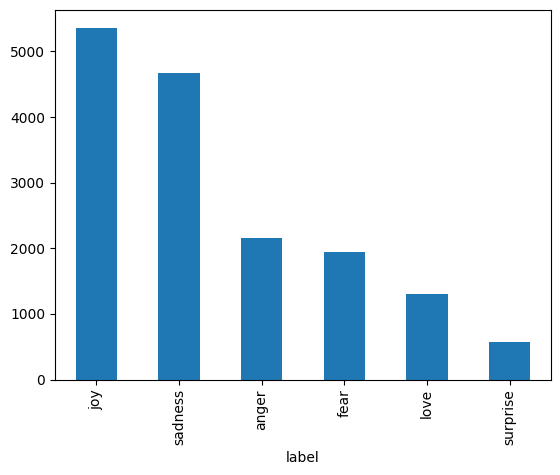

In [52]:
# this tells me that the dataset is kinda balanced and it'll be good for distinguishing joy and sadness

emotions_with_labels.value_counts('label')
emotions_with_labels['label'].value_counts().plot(kind='bar')

In [53]:
emotions_with_labels[emotions_with_labels['label'] == 'love'].head()
emotions_with_labels.isna().sum()
# emotions_with_labels.iloc[14].text

text     0
label    0
dtype: int64

## Preprocessing

In [54]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [55]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)         # remove punctuation
    text = re.sub(r'\d+', '', text)             # remove numbers
    text = re.sub(r'\s+', ' ', text).strip()    # remove extra spaces
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')]) # remove stopwords
    return text

In [ ]:
emotions_with_labels['text'] = emotions_with_labels['text'].apply(preprocess)
emotions_with_labels['text'] = emotions_with_labels['text'].apply(word_tokenize)

In [57]:
emotions_with_labels['text'].head()

0                                didnt feel humiliated
1    go feeling hopeless damned hopeful around some...
2            im grabbing minute post feel greedy wrong
3    ever feeling nostalgic fireplace know still pr...
4                                      feeling grouchy
Name: text, dtype: object

## Wordcloud

In [58]:
from wordcloud import WordCloud

def plot_wordcloud(text):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords.words('english'), 
                min_font_size = 10).generate(text) 
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

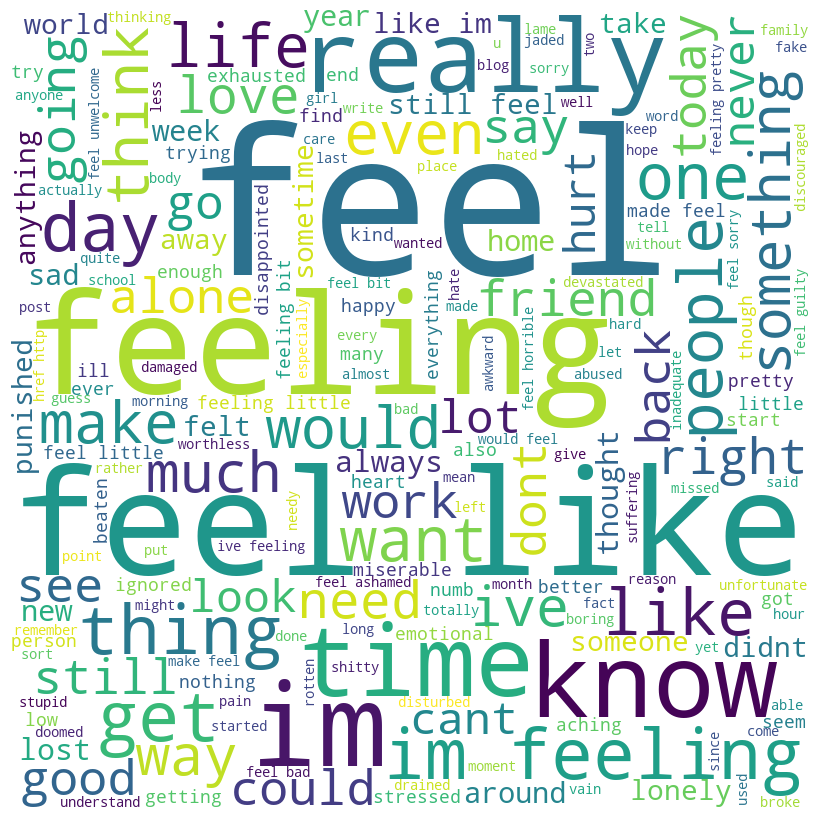

In [59]:
plot_wordcloud(' '.join(emotions_with_labels[emotions_with_labels['label'] == 'sadness']['text']))

## Making the Model - Multinomial Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# splitting data
X = emotions_with_labels['text'].astype(str)  # Ensure text is string type
y = emotions_with_labels['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=7500)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# encode labels if needed
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# train model
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']


MultinomialNB()

In [69]:
y_pred = nb.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6872


## Evaluating Model

              precision    recall  f1-score   support

       anger       0.91      0.38      0.54       427
        fear       0.91      0.30      0.46       397
         joy       0.62      0.98      0.76      1021
        love       1.00      0.06      0.11       296
     sadness       0.71      0.94      0.81       946
    surprise       1.00      0.01      0.02       113

    accuracy                           0.69      3200
   macro avg       0.86      0.45      0.45      3200
weighted avg       0.77      0.69      0.62      3200



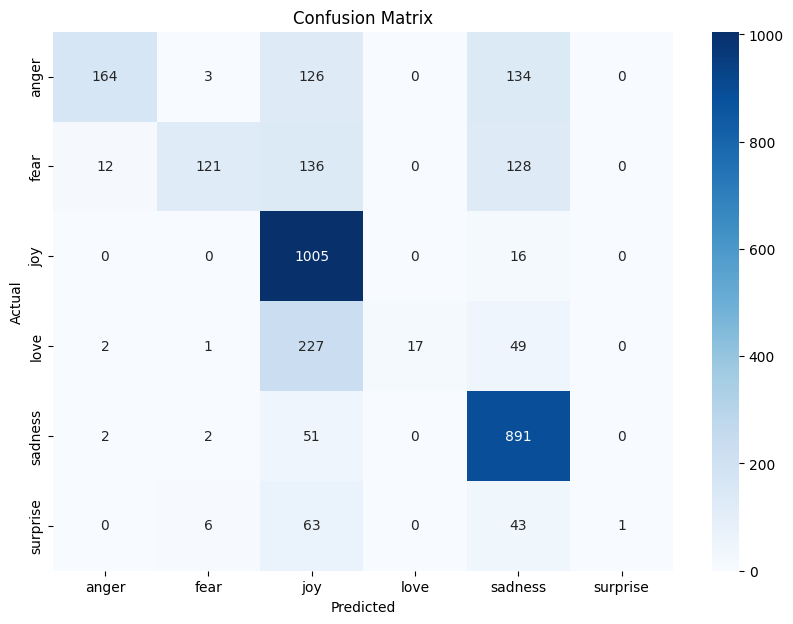

In [87]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# testing the model for fun lol
def predict_emotion(text):
    text = preprocess(text)
    text = " ".join(word_tokenize(text))
    sample_text_tfidf = tfidf.transform([text])

    probs = nb.predict_proba(sample_text_tfidf)[0]  # returns an array of probabilities
    pred = nb.predict(sample_text_tfidf)[0]
    predicted_label = le.inverse_transform([pred])[0]
    class_probs = dict(zip(le.classes_, probs))
    
    return predicted_label, class_probs

In [89]:
label, probabilities = predict_emotion("the way that he ran at me was scary")
print("Predicted Label:", label)

for emotion, prob in probabilities.items():
    print(f'{emotion} - {prob}')

Predicted Label: joy
anger - 0.12970838717403493
fear - 0.1694004362574818
joy - 0.36401447362438855
love - 0.05394956872582229
sadness - 0.25554754475147234
surprise - 0.027379589466799817


## Insights

By using Multinomial Naive Bayes, we can see that it's pretty good at identifying only 'Joy' and 'Sadness', however, it's hard for the model to distinguish other emotions.

This may be partly due to the fact that Naive Bayes takes influence from the prior probability.

In other words, because our training data is mostly labeled as 'Joy' and 'Sadness', our prior probabilities for these sentiments are ~40%.

Because this box has seen mostly 'Joy' and 'Sadness', it tends to automatically "assume" that the text leans towards 'Joy' and 'Sadness'. 

## Making the Model - Recurrent Neural Network

In [92]:
# TODO - embeddings, make RNN (try PyTorch), save model, deploy model